<a href="https://colab.research.google.com/github/tumble-weed/false-gradients/blob/master/deep_relu_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -I --no-cache-dir pillow

    100% |████████████████████████████████| 2.0MB 1.7MB/s 
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.46 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.


In [0]:
import numpy as np
import matplotlib
matplotlib.rcParams['axes.grid'] = False
from matplotlib import pyplot as plt
import torch
tensor_to_numpy = lambda t:t.detach().cpu().numpy()
from termcolor import colored


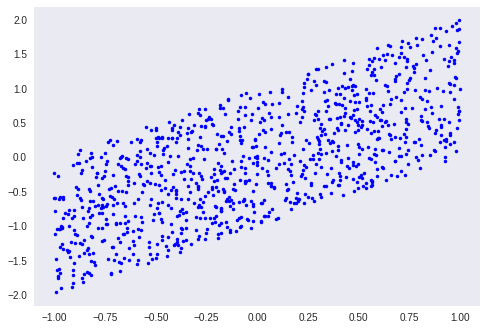

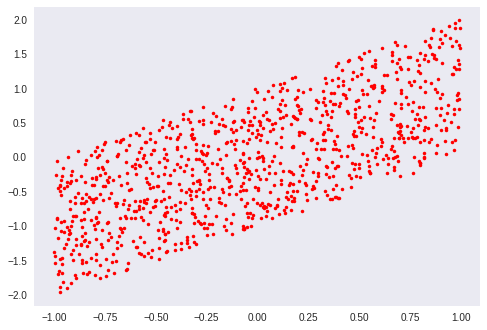

In [0]:
if False:
    print(np.random.rand.__doc__)
npts = 1000
d = 2
x = 2*(np.random.rand(npts,d) - 0.5)
y = x.sum(1)
plt.figure()
plt.plot(x[:,0],y,'.b')

plt.figure()
plt.plot(x[:,1],y,'.r')


In [0]:
torch.nn.init.__dict__

{'__builtins__': {'ArithmeticError': ArithmeticError,
  'AssertionError': AssertionError,
  'AttributeError': AttributeError,
  'BaseException': BaseException,
  'BlockingIOError': BlockingIOError,
  'BrokenPipeError': BrokenPipeError,
  'BufferError': BufferError,
  'BytesWarning': BytesWarning,
  'ChildProcessError': ChildProcessError,
  'ConnectionAbortedError': ConnectionAbortedError,
  'ConnectionError': ConnectionError,
  'ConnectionRefusedError': ConnectionRefusedError,
  'ConnectionResetError': ConnectionResetError,
  'DeprecationWarning': DeprecationWarning,
  'EOFError': EOFError,
  'Ellipsis': Ellipsis,
  'EnvironmentError': OSError,
  'Exception': Exception,
  'False': False,
  'FileExistsError': FileExistsError,
  'FileNotFoundError': FileNotFoundError,
  'FloatingPointError': FloatingPointError,
  'FutureWarning': FutureWarning,
  'GeneratorExit': GeneratorExit,
  'IOError': OSError,
  'ImportError': ImportError,
  'ImportWarning': ImportWarning,
  'IndentationError': Ind

In [0]:
''' for the modified relu '''
def modify_grad_relu(self,gradin,gradout):
    mode = 'descent'
    self.gradin = gradin
    self.gradout = gradout

    gradin = list(gradin)
    if mode == 'descent':
        grad_off = gradin[0] == 0.
        out_grad_at_off = gradout[0][grad_off]
        off_but_positive = -out_grad_at_off>0.
        gradin[0][grad_off] = off_but_positive.type_as(out_grad_at_off) * out_grad_at_off 

    self.modify_gradin = gradin
    
    return tuple(gradin)

def ModReLU():
    relu = torch.nn.ReLU()
    relu.register_backward_hook(modify_grad_relu)
    return relu

In [0]:
# make a linear network
def keep_grad(self,gradin,gradout):
    self.gradout = gradout
    self.gradin = gradin
    
class NonLinNet(torch.nn.Module):
    def __init__(self,insize,lsizes,act_type = 'relu'):
        
        super(NonLinNet,self).__init__()
        self.lsizes = lsizes
        self.insize = insize
        self.layers = []
        self.act_type = act_type
        valid_acts= {'relu':torch.nn.ReLU,
                    'leaky_relu':torch.nn.LeakyReLU,
                    'mod_relu':ModReLU}
        act = valid_acts[act_type]
        for ls in self.lsizes:
            linl = torch.nn.Linear(insize,ls,bias=True)
            _ = linl.register_backward_hook(keep_grad)
            nonlinl = act()
            _ = nonlinl.register_backward_hook(keep_grad)
            self.layers.append(linl)
            self.layers.append(nonlinl)
            insize = ls
        linl = torch.nn.Linear(insize,1,bias=False)
        _ = linl.register_backward_hook(keep_grad)
        self.layers.append(linl)

        self.params = []
        for l in self.layers:
            self.params.extend(list(l.parameters()))
#         self.net = torch.nn.Sequential(*self.layers)
        pass
    def forward(self,x):
        self.fwd_feats = []
        self.relu_feats = []
        for l in self.layers:
            x = l(x)
            x.retain_grad()
            self.fwd_feats.append(x)
            if l.__class__ in [torch.nn.ReLU,
                              torch.nn.LeakyReLU,
                              ModReLU]:
                self.relu_feats.append(x)
        return x
    def init_weights(self,init_type):
        kaiming_nonlinearity = self.act_type
        if kaiming_nonlinearity == 'mod_relu':
            kaiming_nonlinearity = 'relu'
        init_fn_dict = {'orthogonal':torch.nn.init.orthogonal,
                       'xavier_normal':torch.nn.init.xavier_normal,
                        'xavier_uniform':torch.nn.init.xavier_uniform,
                        'kaiming_normal':lambda t:torch.nn.init.kaiming_normal(t,nonlinearity=kaiming_nonlinearity),
                        'kaiming_uniform':lambda t:torch.nn.init.kaiming_uniform(t,nonlinearity=kaiming_nonlinearity),
                       }
        init_fn = init_fn_dict[init_type]            
            
        for l in self.layers:
            p = list(l.parameters()) #p[0] is the weight matrix
            if len(p) > 0:
                init_fn(p[0].data)

In [0]:
def sum_dataset(npts,d):
    X = 2*(torch.rand(npts,d) - 0.5)
    Y = torch.sum(X,dim=-1,keepdim=True)
    mu = torch.mean(X,dim=0)
    std = torch.std(X,dim=0)
    # preprocess = lambda t : (t-mu)/std
    preprocess = lambda t : t
    return X,Y,preprocess    

# def define_net(exp_str,init,act_type):

#     if exp_str == 'D_ladder':
#         n_hid_layer = 20
#         net = NonLinNet(d,[d]*n_hid_layer,act_type = act_type)
#     elif exp_str == 'wide_ladder':
#         n_hid_layer = 20
#         lwidth = 100
#         net = NonLinNet(d,[lwidth]*n_hid_layer,act_type = act_type)
#     net.init_weights(init)

#     return net

def sinusoidal_data(npts,
                   xmin,
                   xmax,
                   radmin,
                   radmax,
                   xnoise_sigma = 0.,
                   ynoise_sigma = 0.,
                   ):

    X = np.linspace(xmin,xmax,npts)
    X = X[:,None]


    ynoise = np.random.randn(npts,1)*ynoise_sigma 
    xnoise = np.random.randn(npts,1)*xnoise_sigma 


    Y = np.cos(xnoise + radmin + (X-xmin)*(radmax-radmin)/(xmax-xmin)) + ynoise
    X = torch.tensor(X).float()
    Y = torch.tensor(Y).float()
#     print(X.shape,
#          Y.shape)
    preprocess = lambda t : t
    return X,Y,preprocess




In [0]:
def define_net(spec_dict):
    net = NonLinNet(spec_dict['input_d'],
                    spec_dict['layer_sizes'],
                    act_type = spec_dict['act_type'],
                   )
    
    net.init_weights(spec_dict['init'])
    return net


In [0]:
from tqdm import tqdm_notebook
def train(net,
          X,
          Y,
          preprocess,
          lr,
          nepochs,
          batch_size,
          ):
    update_avg = lambda avg,n_seen,new_val:(avg*n_seen + new_val)/(n_seen+1.)

    def shuffle(X,Y):
        shuffled_idx = np.random.permutation(X.shape[0])
        return X[shuffled_idx],Y[shuffled_idx]
    Xo,Yo = X,Y   
    
    opt = torch.optim.SGD(net.params,lr =lr)
    trends = {'mse':[],'coeffs':[],'probe_sens':[]}
    last_params = list(net.layers[-1].parameters())
    X_probe = torch.cat((torch.eye(d),torch.zeros(1,d)),0)
    if batch_size is not None:
        nbatches = (X.shape[0] + batch_size -1)//batch_size
    else:
        nbatches = 1
        batch_size = X.shape[0]
#     print(colored('No functionality for minibatches yet','yellow','on_blue'))
    for e in tqdm_notebook(range(nepochs)):
        partial_avg = {'mse':0.}
        X,Y = shuffle(Xo,Yo)
        for bix in range(nbatches):
            bx,by = X[bix*batch_size:(bix+1)*batch_size],Y[bix*batch_size:(bix+1)*batch_size]
            
            pred = net(preprocess(bx))
            loss = torch.nn.functional.mse_loss(pred,by)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            partial_avg['mse'] = update_avg(partial_avg['mse'],
                                            bix,
                                            tensor_to_numpy(loss)) 

        trends['mse'].append(partial_avg['mse'])

        eqv_lin_coeff = net(X_probe)
        trends['coeffs'].append(tensor_to_numpy(eqv_lin_coeff)[:,0])

        ''' Calculate probe sensitivity'''
        e_probe_sens = 0.
        if False:
            probe_pred = net(X_probe[0])
            opt.zero_grad()
            probe_pred.backward()

            e_probe_sens = []
            for lf in net.fwd_feats:
                g = lf.grad
                probe_sens = tensor_to_numpy(g)
            #     print(np.linalg.norm(prob_sens))
                min_probe_sens = np.min(probe_sens)
            #     print(min_probe_sens)
                e_probe_sens.append(min_probe_sens)
        trends['probe_sens'].append(e_probe_sens)
    trends['pred']  = tensor_to_numpy(net(preprocess(Xo)))

    return trends,opt

def data_grad(net,X,trends,opt):
    pred = net(preprocess(X))
    loss = torch.nn.functional.mse_loss(pred,Y)
    opt.zero_grad()
    loss.backward()

    trends['data_grad'] = []
    for lf in net.fwd_feats:
        g = lf.grad
        probe_sens = tensor_to_numpy(g)
    #     print(np.linalg.norm(prob_sens))
        min_probe_sens = np.min(np.abs(probe_sens))
    #     print(min_probe_sens)
        trends['data_grad'].append(min_probe_sens)
    return trends

def visualize_trends(trends):
    trends['coeffs'] = np.array(trends['coeffs'])
    trends['coeffs'][:,0] -= trends['coeffs'][:,-1]
    trends['coeffs'][:,1] -= trends['coeffs'][:,-1]

    plt.figure()
    plt.plot(trends['mse'])
    plt.title('mse')
    plt.figure()
    plt.plot(trends['coeffs'][:,0],'r',label='W_0',)
    plt.plot(trends['coeffs'][:,1],'g',label='W_1',)
    plt.plot(trends['coeffs'][:,2],'b',label='bias',)
    plt.legend()

    trends['probe_sens'] = np.array(trends['probe_sens'])
    plt.figure()
    _ = plt.plot(trends['probe_sens'])
    pass

def visualize_multiple_nets(trends_list):
    
    across_runs = {}
    across_runs['mse'] = np.array([t['mse'] for t in trends_list]).T
    across_runs['data_grad'] = np.array([t['data_grad'] for t in trends_list]).T
    
#     print(across_runs['mse'].shape)
#     print(across_runs['mse'].shape,
#          across_runs['data_grad'].shape)
    
    ''' show MSE '''
    plt.figure()
    plt.plot(np.log10(across_runs['mse']+np.finfo(np.float32).eps))
    plt.title('mse')
    plt.show()
    if across_runs['mse'].size>0:
        print(colored('Minimum MSE %2.3f'%across_runs['mse'].min(),'red','on_yellow'))
    
    ''' show Data_Grad'''
    plt.figure()
#     plt.plot(np.log10(np.abs(across_runs['data_grad'])+1e-7))
    plt.plot(across_runs['data_grad'])
    np.set_printoptions(precision=3)
#     print(colored('Ending Grads' ,across_runs['mse'][:,-1],'red','on_yellow'))
#     print('Ending Grads' ,across_runs['mse'][:,-1])
    plt.title('data_grad')
    plt.show()
    


    pass

def visualize_pred(trends_list,
                  X,
                  Y):
    Y_ = tensor_to_numpy(Y)
    X_ = tensor_to_numpy(X)
    across_runs = {'pred':np.array([t['pred'] for t in trends_list]).T}
    nruns = across_runs['pred'].shape[0]
    ''' show Pred '''
    plt.figure()
    
    plt.plot(np.tile(X_[:,0][:,None],(nruns,1)),
             across_runs['pred'][0,:,:])
    plt.plot(np.tile(X_[:,0][:,None],(nruns,1)),
             np.tile(Y_[:,0][:,None],(nruns,1)),
             'o',
             alpha = 0.2,
            )

    plt.title('pred')
    plt.show()



In [0]:
def activation_map(net,
                  preprocess,
                  X,
                  Y):
    pred = net(preprocess(X))
    fwd_feats = []
    for f in net.fwd_feats[:-1]:
        f_ = tensor_to_numpy(f)
        f_ = (np.abs(f_)>0.).astype(np.float32).sum(0)/f_.shape[0]
        fwd_feats.append(f_)
    fwd_feats = np.array(fwd_feats)
    plt.figure()
    plt.imshow(fwd_feats.T,cmap='jet')
    plt.title('Average Activation across dataset')
    plt.show()
    
    plt.figure()
    plt.imshow(fwd_feats.T>0.,cmap='gray')
    plt.title('is anything always off?')
    plt.show()

#     import pdb;pdb.set_trace()


In [0]:
'''
For one dimensional data, D_ladder doesnt make much sense (with just a single path), 
at least 2 units at some layer has to be there...
'''

'\nFor one dimensional data, D_ladder doesnt make much sense (with just a single path), \nat least 2 units at some layer has to be there...\n'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.


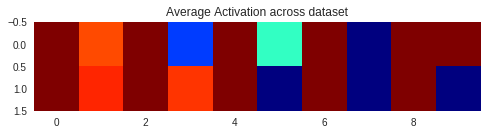

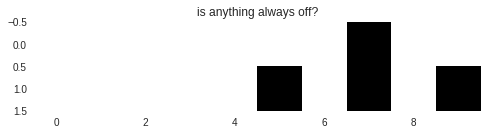

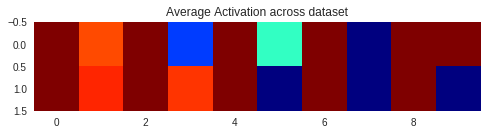

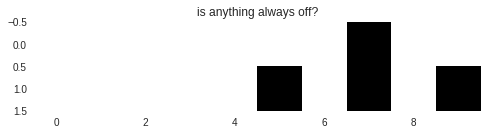

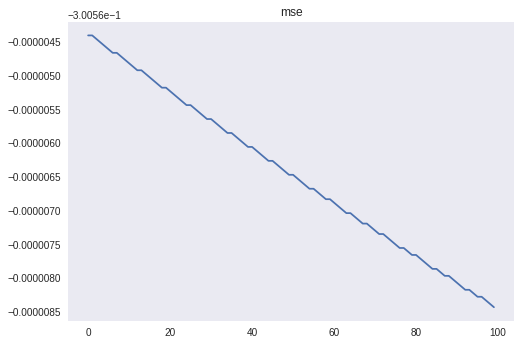

Minimum MSE 0.501


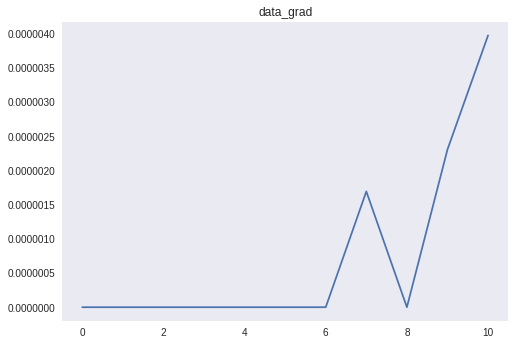

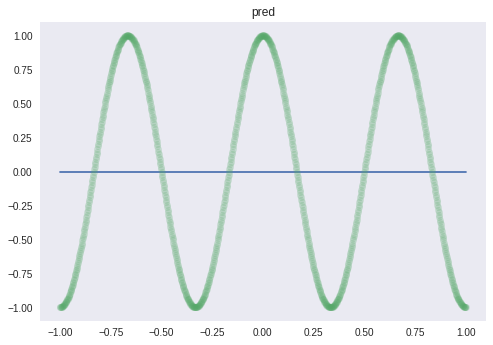

In [0]:
dataset_type = 'cos'
trends_list = []
if dataset_type == 'x1+x2':
    X,Y,preprocess = sum_dataset(npts,d)
elif dataset_type == 'cos':
    X,Y,preprocess = sinusoidal_data(npts=1000,
               xmin=-1,
               xmax=1,
               radmin=-np.pi,
               radmax=5*np.pi,
               xnoise_sigma = 0.,
               ynoise_sigma = 0.,
               )
    d = 1
    
n_runs = 1
exp_str = 'wide_ladder'
act_type = 'relu'
init = 'kaiming_uniform'
n_hid_layer = 5

nepochs,lr,batch_size = 100,1e-3,None

for run_i in range(n_runs):
    ''' Inititalization '''
    if exp_str == 'wide_ladder':
        lwidth = 2
        spec_dict = {'input_d':d,
                     'layer_sizes':[lwidth]*n_hid_layer,
                     'act_type':act_type,
                     'init':init,
                    }
    elif exp_str == 'D_ladder':
        spec_dict = {'input_d':d,
                     'layer_sizes':[d]*n_hid_layer,
                     'act_type':act_type,
                     'init':init,
                    }

    ''' Running the experiment '''
        
    net = define_net(spec_dict)
    activation_map(net,preprocess,X,Y)
    trends,opt=train(net,
                     X,
                     Y,
                     preprocess,
                 lr =lr,
          nepochs = nepochs,
          batch_size = batch_size,)
    activation_map(net,preprocess,X,Y)
    trends = data_grad(net,X,trends,opt)   
#     visualize_trends(trends)
    trends_list.append(trends)
visualize_multiple_nets(trends_list)
visualize_pred(trends_list,X,Y)

In [0]:
pred = net(preprocess(X))
loss = torch.nn.functional.mse_loss(pred,Y)
opt.zero_grad()
loss.backward()
# X.shape
li = -1
print(net.fwd_feats[li].grad.sum(),
trends['data_grad'][li])

tensor(0.0058) 9.806211e-06


In [0]:
''' Agreement between Prediction and Ground Truth '''
nchk = 10
v = torch.cat([net(preprocess(X)),Y],dim=1) 
tensor_to_numpy(v[45:45+nchk])

array([[ 5.614e-06, -6.607e-01],
       [ 1.078e-05, -6.464e-01],
       [ 1.576e-05, -6.319e-01],
       [ 2.133e-05, -6.171e-01],
       [ 2.659e-05, -6.022e-01],
       [ 3.166e-05, -5.870e-01],
       [ 3.692e-05, -5.716e-01],
       [ 4.217e-05, -5.561e-01],
       [ 4.769e-05, -5.403e-01],
       [ 5.192e-05, -5.243e-01]], dtype=float32)

In [0]:
if False:
    '''
    Shows that the sensitivity to canonical input falls off log-linearly
    '''

    probe_pred = net(X_probe[0])
    opt.zero_grad()
    probe_pred.backward()

    trends['probe_sens'] = []
    for lf in net.fwd_feats:
        g = lf.grad
        probe_sens = tensor_to_numpy(g)
    #     print(np.linalg.norm(prob_sens))
        min_probe_sens = np.min(probe_sens)
    #     print(min_probe_sens)
        trends['probe_sens'].append(min_probe_sens)
    plt.figure()
    plt.plot(np.abs(trends['probe_sens']),'.b')
    

In [0]:
if False:
    ''' Gradients w.r.t the actual data to see if some units never get any gradient '''
    pred = net(preprocess(X))
    loss = torch.nn.functional.mse_loss(pred,Y)
    opt.zero_grad()
    loss.backward()

    trends['data_grad'] = []
    for lf in net.fwd_feats:
        g = lf.grad
        probe_sens = tensor_to_numpy(g)
    #     print(np.linalg.norm(prob_sens))
        min_probe_sens = np.min(probe_sens)
    #     print(min_probe_sens)
        trends['data_grad'].append(min_probe_sens)
    plt.figure()
    plt.plot(np.abs(trends['data_grad']),'b')

In [0]:
if False:
    ''' Layer Gradients '''
    for l in net.layers[::-1]:
        g = tensor_to_numpy(l.gradin[-1])
        g = np.abs(g)
    #     print('10e %d',np.ceil(np.log10(g.max())))
        print('10e %d',np.ceil(g.max()))